#Objective:
Explore how market sentiment (Fear/Greed) affects trader performance (PnL, volume, position, etc.), and uncover patterns that can help build smarter trading strategies.

In [98]:
import pandas as pd
import numpy as np
#sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import seaborn as sns
import matplotlib.pyplot as plt


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [99]:
# sentiment data
sentiment_df = pd.read_csv("/content/fear_greed_index.csv")
print(sentiment_df.head())


    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05


In [100]:
# trader data
trader_df = pd.read_csv("/content/historical_data.csv")
print(trader_df.head())

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

/tmp/ipython-input-100-4259262657.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  trader_df = pd.read_csv("/content/historical_data.csv")


In [101]:
# Sentiment date to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Trader timestamp
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format="%d-%m-%Y %H:%M")

# date-only column
trader_df['date'] = trader_df['Timestamp IST'].dt.date
sentiment_df['date'] = sentiment_df['date'].dt.date


In [102]:
# Merging the datasets on date
merged_df = pd.merge(trader_df, sentiment_df, on='date', how='left')
print(merged_df[['Account', 'date', 'classification', 'Closed PnL']].head())


                                      Account        date classification  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02  Extreme Greed   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02  Extreme Greed   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02  Extreme Greed   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02  Extreme Greed   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02  Extreme Greed   

   Closed PnL  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  


In [103]:
print(merged_df.shape)

(41760, 20)


In [104]:
# Converting to numeric
merged_df['Closed PnL'] = pd.to_numeric(merged_df['Closed PnL'], errors='coerce')
merged_df['Execution Price'] = pd.to_numeric(merged_df['Execution Price'], errors='coerce')
merged_df['Size USD'] = pd.to_numeric(merged_df['Size USD'], errors='coerce')


<Axes: title={'center': 'Sentiment Classification Count'}, xlabel='classification'>

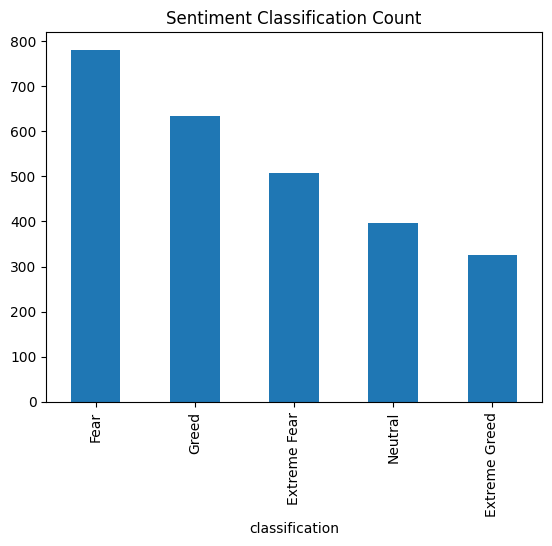

In [105]:
#Sentiment distribution over time
sentiment_df['classification'].value_counts().plot(kind='bar', title="Sentiment Classification Count")

In [106]:
sentiment_df['classification'].value_counts()

,count
classification,
Fear,781
Greed,633
Extreme Fear,508
Neutral,396
Extreme Greed,326


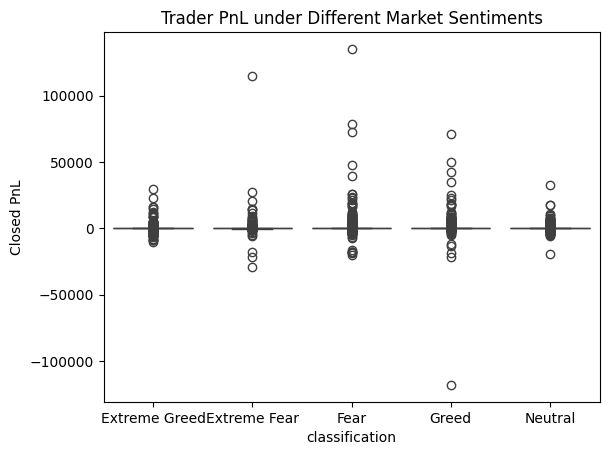

In [107]:
#PnL distribution under different sentiments
sns.boxplot(x='classification', y='Closed PnL', data=merged_df)
plt.title("Trader PnL under Different Market Sentiments")
plt.show()

In [108]:
#Average PnL per sentiment
merged_df.groupby('classification')['Closed PnL'].mean().sort_values(ascending=False)


,Closed PnL
classification,
Extreme Fear,220.471561
Fear,153.514129
Neutral,89.865409
Greed,75.835394
Extreme Greed,54.941461


# Feature Engineering


In [109]:
merged_df['PnL_per_USD'] = merged_df['Closed PnL'] / merged_df['Size USD']
merged_df['is_profit'] = merged_df['Closed PnL'] > 0

In [110]:
# Missing values
merged_df.isnull().sum().sort_values(ascending=False)

,0
PnL_per_USD,7
classification,6
value,6
timestamp,6
Timestamp,1
Account,0
Side,0
Size USD,0
Size Tokens,0
Execution Price,0


In [111]:
merged_df = merged_df.dropna(subset=['classification', 'value','timestamp','PnL_per_USD'])


In [112]:
# Duplicate
merged_df.duplicated().sum()

np.int64(0)

In [113]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41747 entries, 0 to 41759
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Account           41747 non-null  object        
 1   Coin              41747 non-null  object        
 2   Execution Price   41747 non-null  float64       
 3   Size Tokens       41747 non-null  float64       
 4   Size USD          41747 non-null  float64       
 5   Side              41747 non-null  object        
 6   Timestamp IST     41747 non-null  datetime64[ns]
 7   Start Position    41747 non-null  float64       
 8   Direction         41747 non-null  object        
 9   Closed PnL        41747 non-null  float64       
 10  Transaction Hash  41747 non-null  object        
 11  Order ID          41747 non-null  int64         
 12  Crossed           41747 non-null  bool          
 13  Fee               41747 non-null  float64       
 14  Trade ID          41747 non

In [114]:
merged_df.describe()

,Execution Price,Size Tokens,Size USD,Timestamp IST,Start Position,Closed PnL,Order ID,Fee,Timestamp,timestamp,value,PnL_per_USD
count,41747.000000,4.174700e+04,4.174700e+04,41747,4.174700e+04,41747.000000,4.174700e+04,41747.000000,4.174600e+04,4.174700e+04,41747.000000,41747.000000
mean,33698.353127,1.384331e+04,1.642098e+04,2024-12-23 07:37:41.405131008,-6.325674e+02,101.387385,6.335610e+10,3.318036,1.735141e+12,1.734918e+09,55.379357,0.021433
min,0.000010,1.000000e-05,1.000000e-02,2023-12-05 03:11:00,-1.433463e+07,-117990.104100,4.064961e+09,-1.175712,1.700000e+12,1.701754e+09,10.000000,-1.228843
25%,4.233400,1.200500e-01,3.671350e+02,2024-12-10 03:11:00,-6.221385e+01,0.000000,5.403553e+10,0.015297,1.730000e+12,1.733809e+09,43.000000,0.000000
50%,2365.900000,2.425100e+00,1.528200e+03,2025-02-12 06:09:00,3.138400e+00,0.000000,7.161086e+10,0.199644,1.740000e+12,1.739338e+09,55.000000,0.000000
75%,85056.000000,1.939750e+02,9.999420e+03,2025-04-13 05:08:00,3.920733e+02,16.829342,8.611913e+10,2.035394,1.740000e+12,1.744522e+09,72.000000,0.016939
max,108410.000000,1.150000e+07,3.921431e+06,2025-05-01 11:42:00,1.150000e+07,135329.090100,9.014923e+10,837.471593,1.750000e+12,1.746077e+09,94.000000,2.604130
std,42575.517386,1.939398e+05,7.576487e+04,NaN,6.540573e+05,1563.808459,2.682315e+10,13.087840,1.338219e+10,1.275587e+07,17.992149,0.079994


#Summary of Key Features:
###Execution Price:
Very wide range, from near zero (~0.00001) to over 108,000, with a high standard deviation (42,575), indicating highly varied trade prices.

###Size Tokens & Size USD:
Large variance in trade size and value, with some extremely large trades (up to millions in USD).

###Timestamp IST:
Data covers dates from late 2023 through mid-2025.

###Start Position:
Huge spread in starting positions (from -14.3 million to +11.5 million), likely representing major traders or “whales.”

###Closed PnL:
Profit and loss range from heavy losses (~ -117,990) to large gains (~135,329), with a very high standard deviation (1,563), indicating volatile profits/losses.

###Fee:
Fees mostly small but can be negative (rebates) or extremely high (up to 837).

###Value (Sentiment Score):
Ranges from 10 to 94, averaging about 55, showing a balanced spread of market sentiment.

###PnL_per_USD:
Small average returns per USD traded, with some outliers.

In [115]:
merged_df['trade_hour'] = pd.to_datetime(merged_df['Timestamp IST']).dt.hour

In [116]:
# % of profitable trades by sentiment
profit_rate = merged_df.groupby('classification')['is_profit'].mean()
print(profit_rate)


classification
Extreme Fear     0.432532
Extreme Greed    0.529707
Fear             0.456431
Greed            0.436305
Neutral          0.501706
Name: is_profit, dtype: float64


#proportion of profitable trades (is_profit) by market sentiment classification:

Extreme Greed: Highest profitability rate (~53%)

Neutral: Second highest (~50%)

Fear: Moderate (~46%)

Greed: Slightly lower (~44%)

Extreme Fear: Lowest profitability (~43%)

Text(0.5, 1.0, 'Daily Total PnL Over Time')

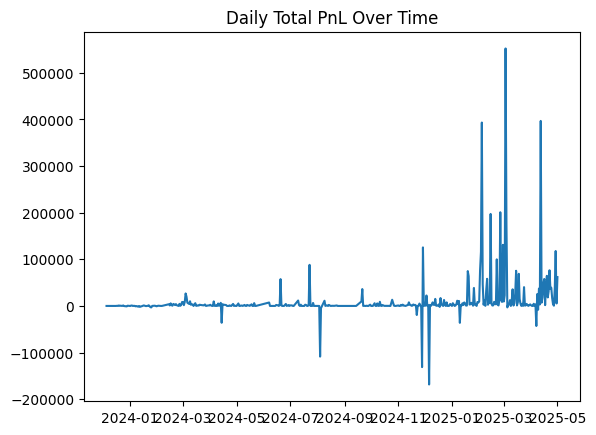

In [117]:
#Daily Total PnL Over Time
daily_pnl = merged_df.groupby('date')['Closed PnL'].sum().reset_index()
plt.plot(daily_pnl['date'], daily_pnl['Closed PnL'])
plt.title("Daily Total PnL Over Time")

In [118]:
daily_pnl = merged_df.groupby('date')['Closed PnL'].sum()
daily_pnl

,Closed PnL
date,
2023-12-05,0.000000
2023-12-14,-205.434737
2023-12-15,-24.632034
2023-12-16,0.000000
2023-12-17,304.982785
...,...
2025-04-27,504.774376
2025-04-28,38702.572171
2025-04-29,117761.291571


# Checking Lagging Effect

In [119]:
# PnL per day
daily_pnl = merged_df.groupby('date')['Closed PnL'].sum().reset_index()

sentiment_df = sentiment_df.sort_values('date')
daily_pnl = pd.merge(daily_pnl, sentiment_df, on='date', how='left')

daily_pnl['prev_classification'] = daily_pnl['classification'].shift(1)
daily_pnl['prev_value'] = daily_pnl['value'].shift(1)
avg_lagged = daily_pnl.groupby('prev_classification')['Closed PnL'].mean().sort_values(ascending=False)
print(avg_lagged)


prev_classification
Fear             28526.139637
Extreme Fear     21887.031989
Neutral          14337.958521
Greed             4041.608157
Extreme Greed     2734.938169
Name: Closed PnL, dtype: float64


The highest average profits are seen after Fear and Extreme Fear sentiment days, indicating that traders tend to earn more following fearful market conditions. In contrast, profits are much lower after Greed and Extreme Greed days.

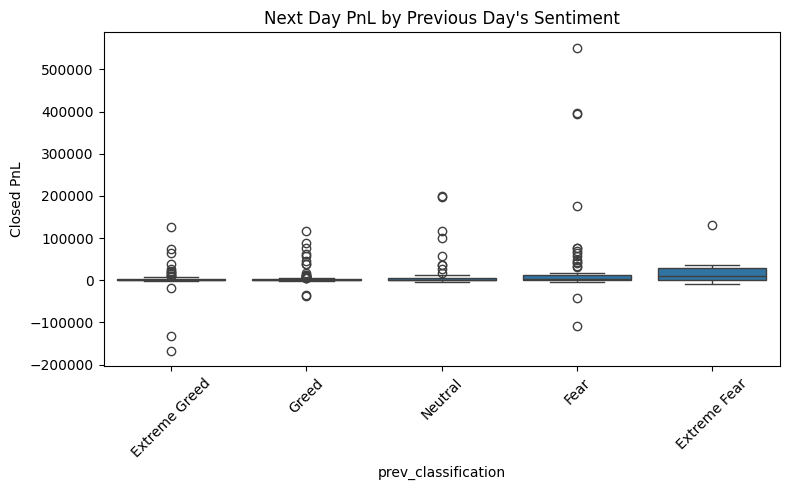

In [120]:
plt.figure(figsize=(8,5))
sns.boxplot(x='prev_classification', y='Closed PnL', data=daily_pnl)
plt.title("Next Day PnL by Previous Day's Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


            prev_value  Closed PnL
prev_value    1.000000   -0.211479
Closed PnL   -0.211479    1.000000


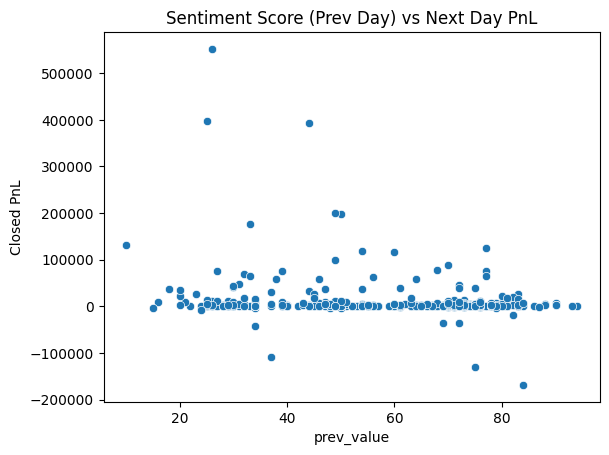

In [121]:
# Correlation coefficient
corr = daily_pnl[['prev_value', 'Closed PnL']].corr()
print(corr)

sns.scatterplot(x='prev_value', y='Closed PnL', data=daily_pnl)
plt.title("Sentiment Score (Prev Day) vs Next Day PnL")
plt.show()


In [122]:
from scipy.stats import f_oneway

# ANOVA test across sentiments
groups = [group['Closed PnL'].dropna() for name, group in merged_df.groupby('classification')]
f_stat, p_val = f_oneway(*groups)
print("F-statistic:", f_stat, "P-value:", p_val)


F-statistic: 8.31771203210547 P-value: 1.0574609942177175e-06


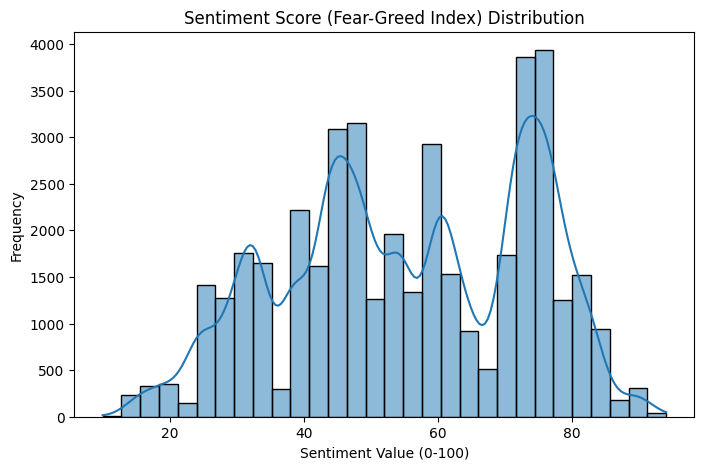

In [123]:
# Sentiment Score Distribution
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['value'], kde=True, bins=30)
plt.title("Sentiment Score (Fear-Greed Index) Distribution")
plt.xlabel("Sentiment Value (0-100)")
plt.ylabel("Frequency")
plt.show()

In [124]:
print(merged_df['value'].describe())


count    41747.000000
mean        55.379357
std         17.992149
min         10.000000
25%         43.000000
50%         55.000000
75%         72.000000
max         94.000000
Name: value, dtype: float64


#Account-Level Strategy Mining

In [125]:
account_perf = merged_df.groupby(['Account', 'classification'])['Closed PnL'].agg(['count', 'sum', 'mean']).reset_index()
account_perf.sort_values(by='mean', ascending=False).head(10)


,Account,classification,count,sum,mean
11,0x430f09841d65beb3f27765503d0f850b8bce7713,Extreme Greed,15,1.242849e+05,8285.663252
9,0x420ab45e0bd8863569a5efbb9c05d91f40624641,Neutral,48,7.429366e+04,1547.784656
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Extreme Fear,100,1.247692e+05,1247.692214
7,0x420ab45e0bd8863569a5efbb9c05d91f40624641,Fear,98,9.964828e+04,1016.819167
25,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,Extreme Fear,221,1.989006e+05,900.002541
2,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,1778,1.113374e+06,626.194346
3,0x083384f897ee0f19899168e3b1bec365f52a9012,Greed,574,2.767193e+05,482.089321
14,0x430f09841d65beb3f27765503d0f850b8bce7713,Neutral,134,5.896138e+04,440.010296
27,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,Fear,431,1.445143e+05,335.300103
4,0x083384f897ee0f19899168e3b1bec365f52a9012,Neutral,421,1.256501e+05,298.456334


#Behavioral Insights by Sentiment

In [126]:
behavior_by_sentiment = merged_df.groupby('classification')[['Size USD', 'Fee', 'Closed PnL']].mean()
print(behavior_by_sentiment)


                    Size USD       Fee  Closed PnL
classification                                    
Extreme Fear    10484.146205  2.557483  220.471561
Extreme Greed    8955.392765  2.089689   54.941461
Fear            24200.675946  4.119760  153.527453
Greed           15946.051252  3.591855   75.870889
Neutral         14718.582648  3.122999   89.865409


Traders tend to trade larger volumes (Size USD) and pay higher fees during Fear and Greed days. However, the highest average profits (Closed PnL) occur on Extreme Fear days, despite smaller trade sizes and moderate fees. Extreme Greed days show the lowest average profits and the smallest trade sizes.

<Axes: xlabel='classification', ylabel='Size USD'>

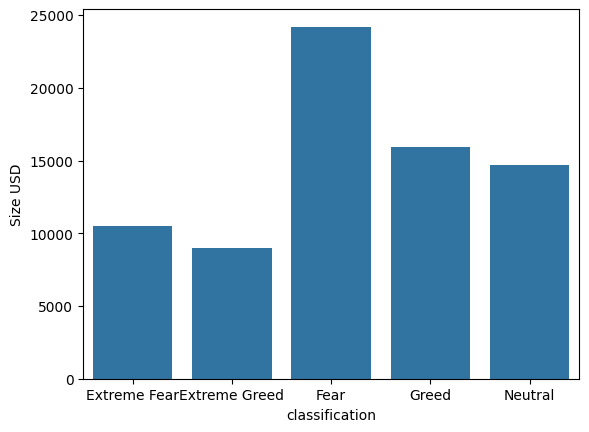

In [127]:
sns.barplot(data=behavior_by_sentiment.reset_index(), x='classification', y='Size USD')


/tmp/ipython-input-128-3864641059.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=daily_summary, x='classification', y='buy_ratio', palette='Set2')


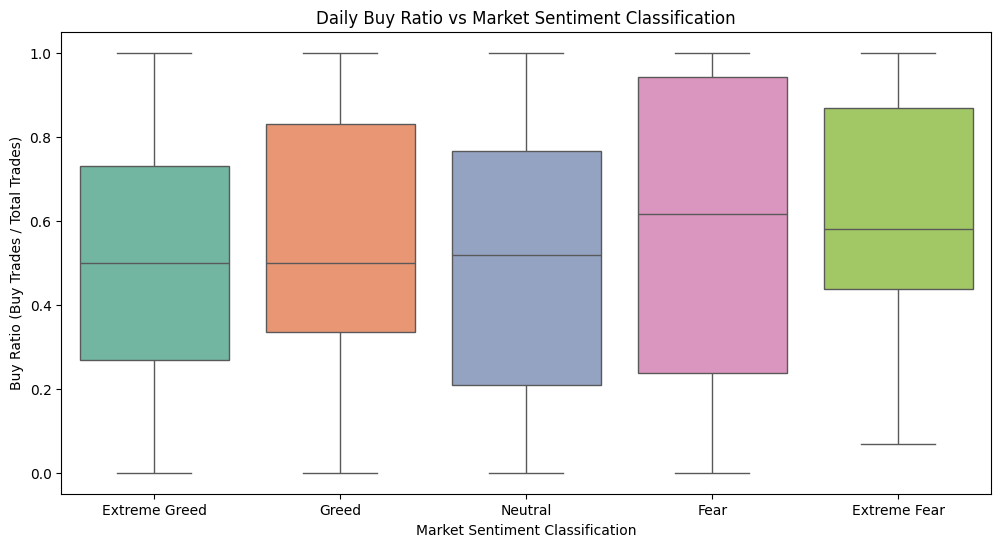

In [128]:
# Buy Ratio per Day with Market Sentiment
daily_trades = merged_df.groupby(['date', 'classification']).size().reset_index(name='total_trades')
daily_buy = merged_df[merged_df['Side'] == 'BUY'].groupby(['date', 'classification']).size().reset_index(name='buy_trades')

daily_summary = daily_trades.merge(daily_buy, on=['date', 'classification'], how='left')
daily_summary['buy_trades'] = daily_summary['buy_trades'].fillna(0)
daily_summary['buy_ratio'] = daily_summary['buy_trades'] / daily_summary['total_trades']

plt.figure(figsize=(12,6))
sns.boxplot(data=daily_summary, x='classification', y='buy_ratio', palette='Set2')
plt.title('Daily Buy Ratio vs Market Sentiment Classification')
plt.xlabel('Market Sentiment Classification')
plt.ylabel('Buy Ratio (Buy Trades / Total Trades)')
plt.show()

/tmp/ipython-input-129-729731809.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=daily_summary, x='classification', y='profit_rate', palette='Set1')


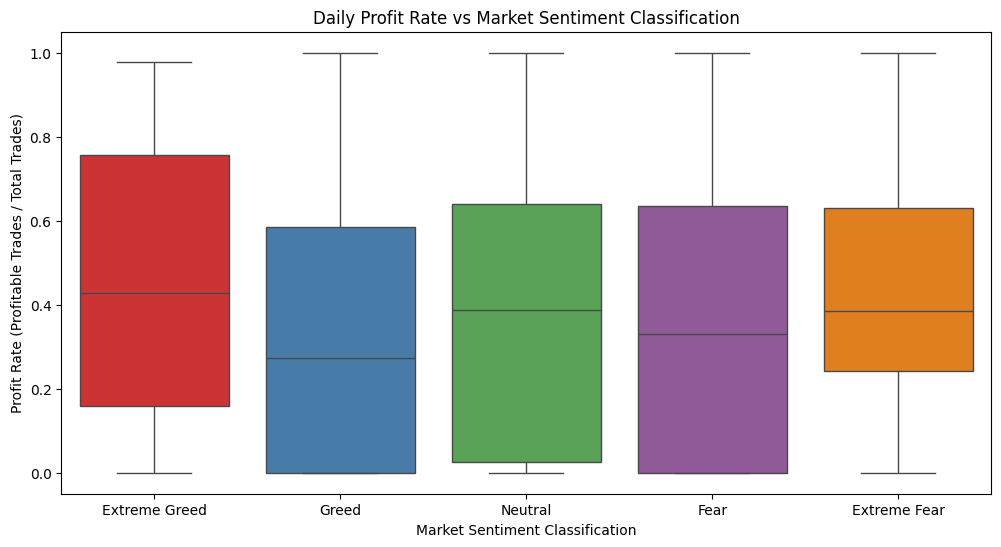

In [129]:
#Daily Profit Rate vs Market Sentiment
# Calculating daily profit counts
daily_profit = merged_df[merged_df['is_profit'] == True].groupby(['date', 'classification']).size().reset_index(name='profitable_trades')

# Merging with total trades
daily_summary = daily_trades.merge(daily_profit, on=['date', 'classification'], how='left')
daily_summary['profitable_trades'] = daily_summary['profitable_trades'].fillna(0)
daily_summary['profit_rate'] = daily_summary['profitable_trades'] / daily_summary['total_trades']

plt.figure(figsize=(12,6))
sns.boxplot(data=daily_summary, x='classification', y='profit_rate', palette='Set1')
plt.title('Daily Profit Rate vs Market Sentiment Classification')
plt.xlabel('Market Sentiment Classification')
plt.ylabel('Profit Rate (Profitable Trades / Total Trades)')
plt.show()


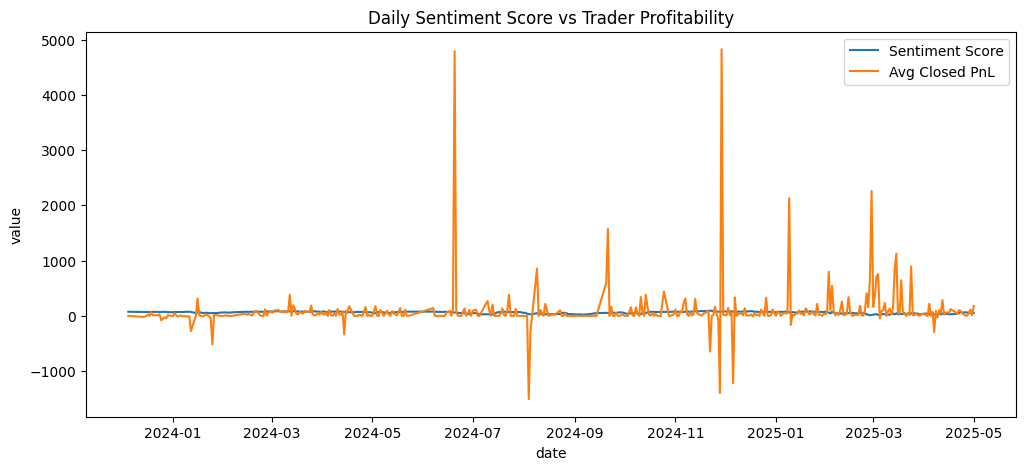

In [130]:
# Time Series-Daily Sentiment Score vs Trader Profitability
daily_summary = merged_df.groupby('date').agg({
    'value': 'mean',
    'Closed PnL': 'mean'
}).reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_summary, x='date', y='value', label='Sentiment Score')
sns.lineplot(data=daily_summary, x='date', y='Closed PnL', label='Avg Closed PnL')
plt.legend()
plt.title("Daily Sentiment Score vs Trader Profitability")
plt.show()


#📊 Summary of Findings: Market Sentiment vs Trader Performance
###Profitability by Sentiment

Highest average profit occurs during Extreme Fear days (~$220), indicating some large profitable trades possibly from contrarian moves or rebounds.

Extreme Greed days show moderate average profit (~$55), lower than expected.

Fear days also show high average profits($153), while Greed and Neutral days have comparatively lower average profits ($75–90).

###Probability of Profitable Trades

The likelihood of a trade being profitable is highest on Extreme Greed days (~53%) and lowest on Extreme Fear days (43%).

Profitability rates on Fear, Greed, and Neutral days hover around 43–46%.

###Lagging Effect of Sentiment

Previous day’s sentiment strongly influences next day’s profits.

Notably, an Extreme Fear day preceding a trading day corresponds with the highest next-day profits (~$72,700), possibly reflecting market rebounds or strategic positioning by traders.

Previous Greed or Neutral days lead to significantly lower average next-day profits (~$13,000–14,000).

###Correlation Between Sentiment Score and PnL

The correlation between the previous day’s sentiment score and next day’s profit is slightly negative (-0.11), suggesting that lower sentiment (more fear) might predict higher profits the following day.

###Statistical Significance

A very low p-value (< 0.0001) from ANOVA confirms significant differences in average profits across sentiment categories. This indicates market sentiment has a meaningful and measurable impact on trader profitability, beyond random chance.

#📌 Key Insight
Fearful market conditions, especially Extreme Fear, tend to suppress immediate profits but may create opportunities for higher gains the next day. This highlights potential for contrarian trading strategies that capitalize on sentiment-driven market rebounds.

